In [29]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [30]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_date = '2017_11_21'
exp_name = '2017_11_21_10_19_24_ss-readout-test'
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)

In [31]:
q.experiments[0]['variable_list']

[]

In [39]:
#results = q.generate_thresholds()
q.set_thresholds([[20],[5]])

In [40]:
retention = q.apply_thresholds()

In [41]:
tbl_str = "ivar:\t{0}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.0	retention:0.984 +- 0.001


In [42]:
q.save_experiment_data()

<IPython.core.display.Javascript object>


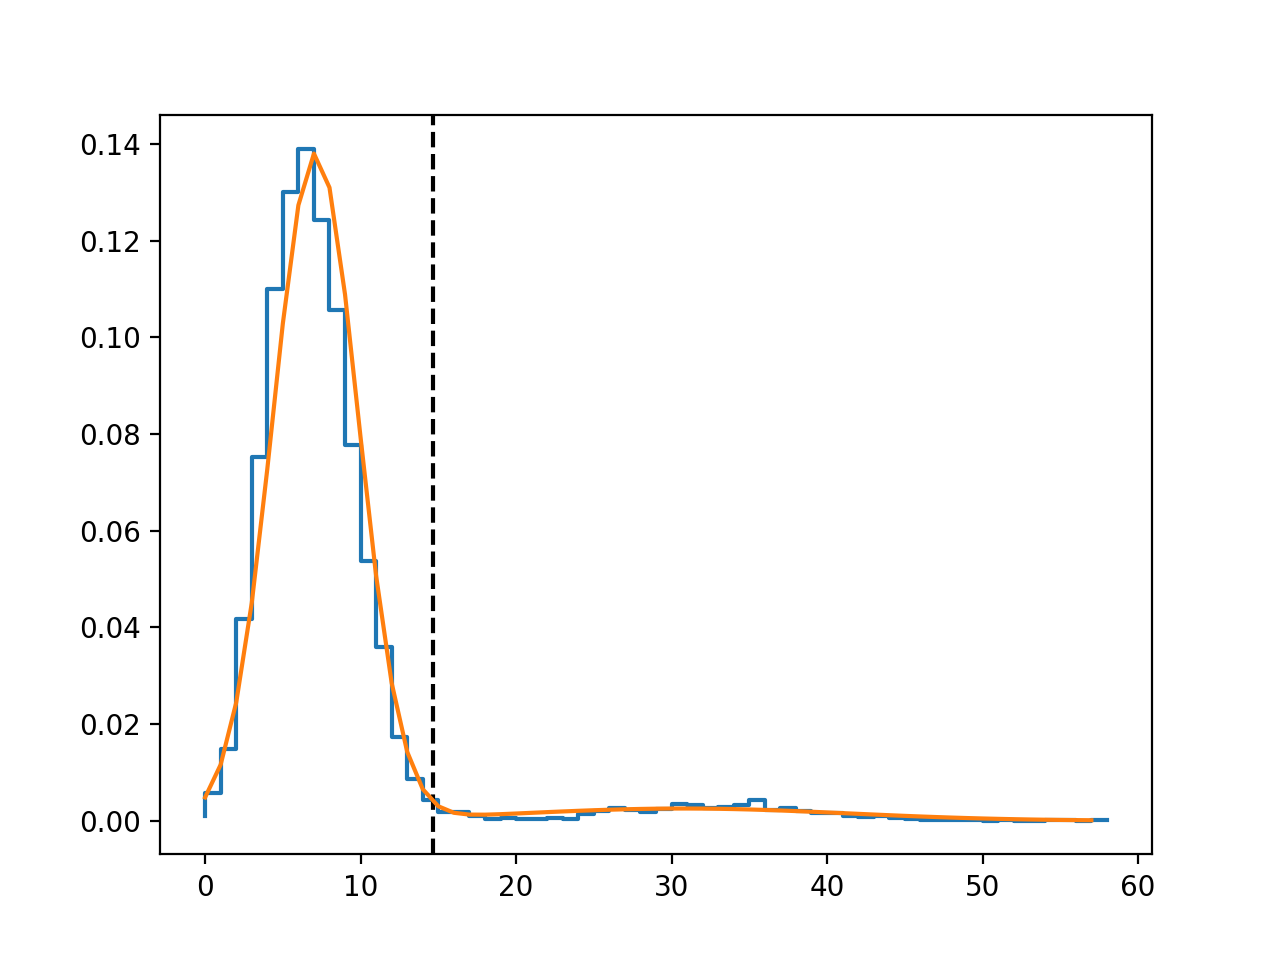

[14.67838942437033]


In [43]:
s=0
shift = 0
fig, ax = plt.subplots()
ax.step(results[s]['hist_x']+shift, results[s]['hist_y'])
xs = np.arange(max(results[0]['hist_x']))

for xc in results[s]['cuts']:
    plt.axvline(x=xc, color='k', linestyle='--')

ax.plot(xs, qdp.dblgauss(xs, *results[s]['fit_params']))
print(results[s]['cuts'])

<IPython.core.display.Javascript object>


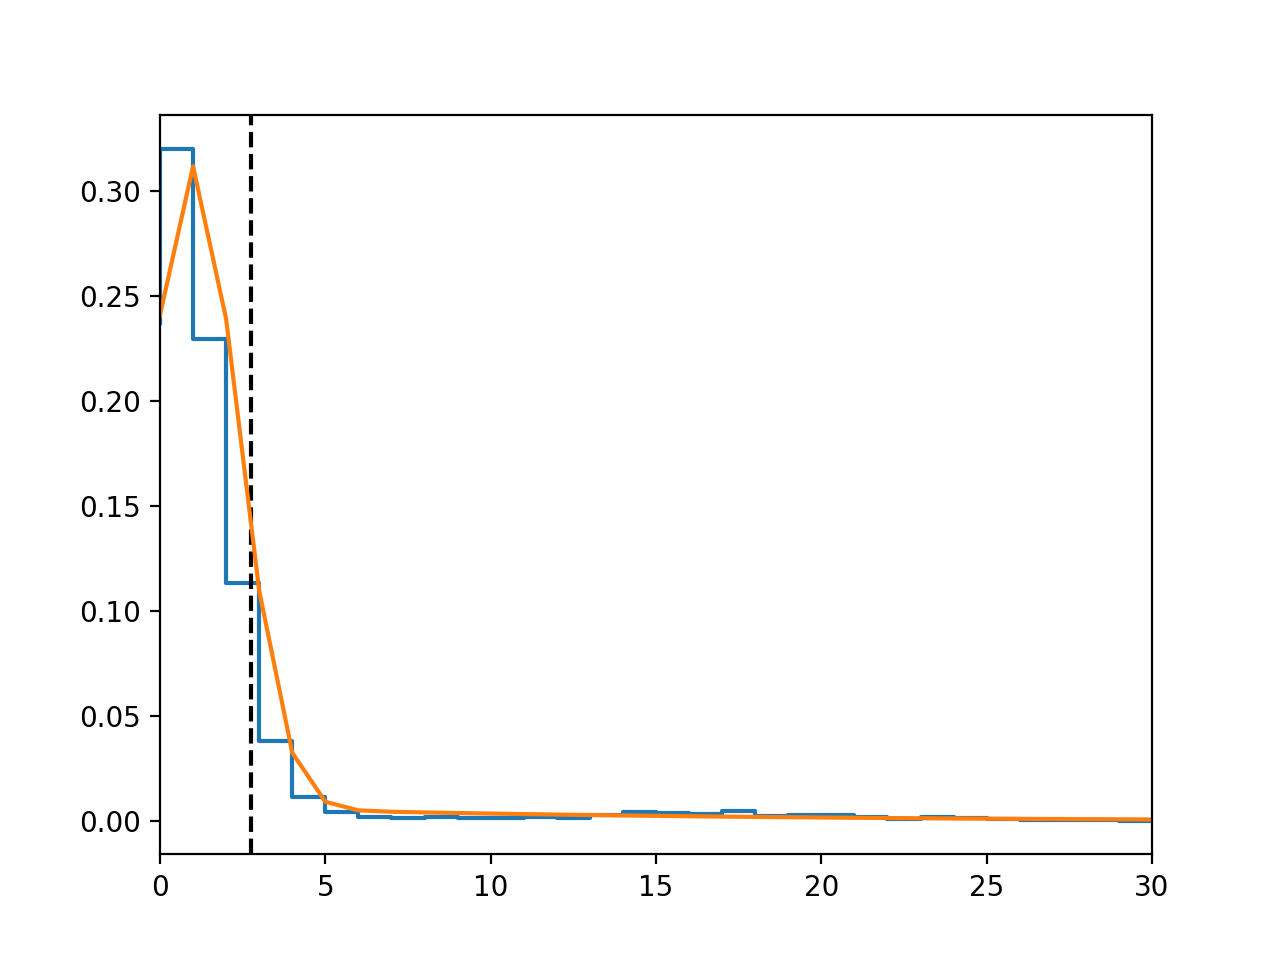

[2.7617866797970629]


In [44]:
s=1
shift = 0
fig, ax = plt.subplots()
ax.step(results[s]['hist_x']+shift, results[s]['hist_y'])
xs = np.arange(max(results[0]['hist_x']))

for xc in results[s]['cuts']:
    plt.axvline(x=xc, color='k', linestyle='--')

ax.plot(xs, qdp.dblgauss(xs, *results[s]['fit_params']))
ax.set_xlim(0, 30)
print(results[s]['cuts'])

<IPython.core.display.Javascript object>


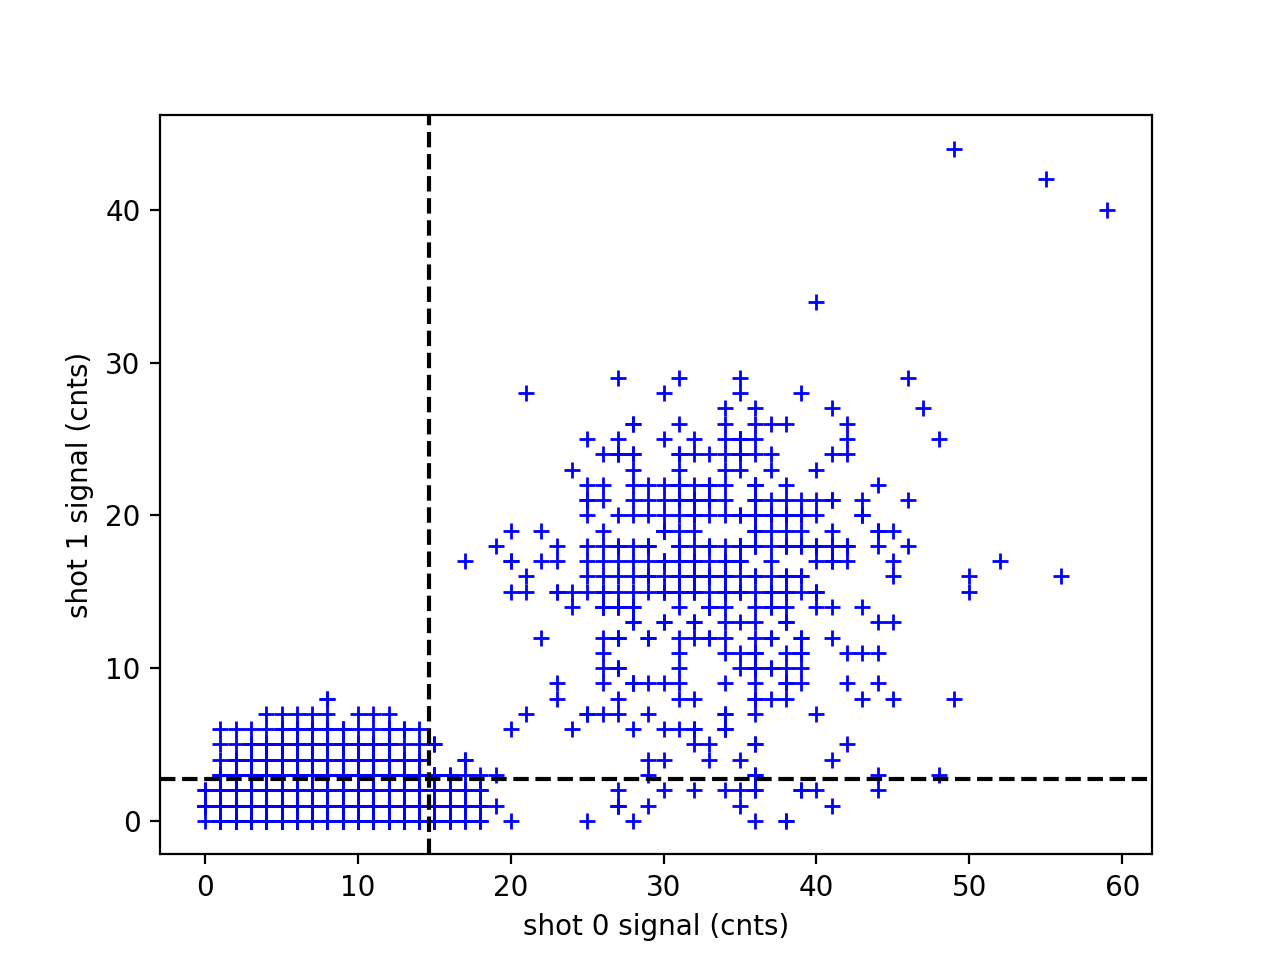

Text(0,0.5,u'shot 1 signal (cnts)')

In [38]:
fig, ax = plt.subplots()
s0_data = q.experiments[0]['iterations'][0]['signal_data'][:,0]
s1_data = q.experiments[0]['iterations'][0]['signal_data'][:,1]
ax.plot(s0_data, s1_data, 'b+')

for xc in results[0]['cuts']:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in results[1]['cuts']:
    plt.axhline(y=xc, color='k', linestyle='--')

ax.set_xlabel('shot 0 signal (cnts)')
ax.set_ylabel('shot 1 signal (cnts)')